## 色関係

In [1]:
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
from pathlib import Path
import statistics
import matplotlib
matplotlib.use('Agg') # -----(1)
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport # profile report を作る用
import cv2
import seaborn as sns
import umap

In [2]:
DATA_DIR = Path("/home/knikaido/work/atma10/data/")

In [3]:
SEED = 42
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 200,
}

SAVE_TEST_SUB_PATH = "sub01.csv"

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [5]:
train_df = pd.read_csv(DATA_DIR / Path('train.csv'))
test_df = pd.read_csv(DATA_DIR / Path('test.csv'))
palette_df = pd.read_csv(DATA_DIR / Path('palette.csv'))
palette_df

,ratio,color_r,color_g,color_b,object_id
0,0.013781,40,4,0,000405d9a5e3f49fc49d
1,0.040509,221,189,129,000405d9a5e3f49fc49d
2,0.036344,207,175,117,000405d9a5e3f49fc49d
3,0.033316,230,197,129,000405d9a5e3f49fc49d
4,0.039600,194,161,106,000405d9a5e3f49fc49d
...,...,...,...,...,...
527885,0.019645,158,123,65,ffff22ea12d7f99cff31
527886,0.023526,79,54,28,ffff22ea12d7f99cff31
527887,0.009999,60,37,14,ffff22ea12d7f99cff31
527888,0.052426,107,81,49,ffff22ea12d7f99cff31


色をパレットにするやつ
https://www.guruguru.science/competitions/16/discussions/0cf48a1f-59fd-45b1-880a-cf9fc54d6912/

In [6]:
train_df_top20 = train_df.sort_values('likes', ascending=False).head(20)

fig = plt.figure(figsize=(20, 20))

palette_df_top20 = palette_df.merge(train_df_top20, how='inner', on='object_id').sort_values(['likes', 'object_id'])

for i, (index, df) in enumerate(palette_df_top20.groupby('object_id')):
    ax = fig.add_subplot(5, 4, i+1)

    left = 0
    r_s = []
    b_s = []
    g_s = []
    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
        
        left += row['ratio']
    ax.set_title('{}, likes={}'.format(row['object_id'], row['likes']))
#     print(np.std(r_s), np.std(g_s), np.std(b_s))

In [7]:
train_df_bottom20 = train_df.sort_values('likes', ascending=True).head(20)

fig = plt.figure(figsize=(20, 20))

palette_df_bottom20 = palette_df.merge(train_df_bottom20, how='inner', on='object_id').sort_values(['likes', 'object_id'])

for i, (index, df) in enumerate(palette_df_bottom20.groupby('object_id')):
    ax = fig.add_subplot(5, 4, i+1)

    left = 0
    r_s = []
    b_s = []
    g_s = []
    for index, row in df.sort_values('ratio', ascending=False).iterrows():
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])

        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
        ax.set_title('{}, likes={}'.format(row['object_id'], row['likes']))
        left += row['ratio']
#     print(np.std(r_s), np.std(g_s), np.std(b_s))

### 彩度を出してみる

In [8]:

def get_hsv_report(rgb_image, plot_show = False, statistics_show=False):
    """HSV色座標系に変換してヒストグラムを表示する。さらにパーセントタイルを利用して全体的に明るい、暗いなどを検出する


    Args:
        rgb_image(obj): rgbイメージ画像
        plot_show(bool): hsv票色系のグラフをプロットするか
        statistics_show(bool):標準偏差を出力するか(処理が重い)

    Returns:
       hsv票色系のパーセントタイルの値

    """
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HSV) # hsv票色系に変換
    h,s,v = cv2.split(hsv) # 各成分に分割
    
    def get_percentile_list(k, datas):
            #ここでは、パーセントタイルを 5,50,95パーセントとする。
            #パーセントタイルを利用して、輝度より明るい、暗い画像を判定などに利用する
            percentile = [5,50,95] #パーセントタイルの設定。ここは、必要に応じて変更する
            out_datas = {}
            for i in percentile:
                value = np.percentile(np.array(datas), i)
                s = k + "_"+str(i) 
                out_datas[s] = value
            return out_datas
    
    out_dict = {}
    
    plt.figure(figsize=(8, 5))
    
    #色相
    if(plot_show == True):
        plt.hist(h.ravel(),256,[0,256], color="red", alpha=0.7, histtype="step", label="Hue")
    data = get_percentile_list("h_per",h.ravel())
    out_dict.update(data)
    
    if(statistics_show == True):
        out_dict['h_pstdev'] =  statistics.pstdev(h.ravel()/255)
    
    #彩度
    if(plot_show == True):
        plt.hist(s.ravel(),256,[0,256], color="green",  alpha=0.7, histtype="step", label="Saturation")
    data = get_percentile_list("s_per",s.ravel())
    out_dict.update(data)
    if(statistics_show == True):
        out_dict['s_pstdev'] =  statistics.pstdev(s.ravel()/255)
    
    #輝度
    if(plot_show == True):
        plt.hist(v.ravel(),256,[0,256], color="blue",  alpha=0.7, histtype="step",label="Value")
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
        plt.show()
        
    data = get_percentile_list("v_per",v.ravel())
    out_dict.update(data)
    if(statistics_show == True):
        out_dict['v_pstdev'] =  statistics.pstdev(v.ravel()/255)
    
    return s.ravel()

In [9]:
s_s = []

for i, (index, df) in tqdm(enumerate(palette_df_top20.groupby('object_id'))):
#     if(i == 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()
    left = 0

    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
#         ax.barh(0, 1/len(df), color=color, left=left)
        ax.set_title('{}'.format(row['object_id']))

#         left += 1/len(df)
        left += row['ratio']

    fig.canvas.draw()
    im = np.array(fig.canvas.renderer.buffer_rgba())
    # im = np.array(fig.canvas.renderer._renderer) # matplotlibが3.1より前の場合
    im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR)
    s_ = get_hsv_report(im, True, True)
    print(s_)
    
    break
#     print(np.percentile(np.array(h.ravel()), 80), np.percentile(np.array(h.ravel()), 95))
#     break

0it [00:01, ?it/s]

[0 0 0 ... 0 0 0]


In [10]:
plt.plot(s_)

In [11]:
s_s = []

for i, (index, df) in tqdm(enumerate(palette_df_bottom20.groupby('object_id'))):
#     if(i == 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()
    left = 0

    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
#         ax.barh(0, 1/len(df), color=color, left=left)
        ax.set_title('{}'.format(row['object_id']))

#         left += 1/len(df)
        left += row['ratio']

    fig.canvas.draw()
    im = np.array(fig.canvas.renderer.buffer_rgba())
    # im = np.array(fig.canvas.renderer._renderer) # matplotlibが3.1より前の場合
    im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR)
    s__ = get_hsv_report(im, True, True)
    print(s__)
    
    break
#     print(np.percentile(np.array(h.ravel()), 80), np.percentile(np.array(h.ravel()), 95))
#     break

0it [00:01, ?it/s]

[0 0 0 ... 0 0 0]


In [28]:
len(s_)

82944

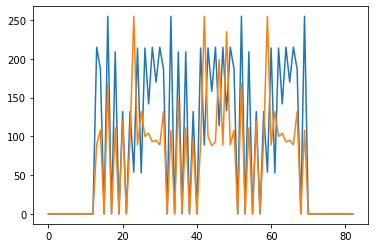

In [32]:
plt.plot(s_[::1000])
plt.plot(s__[::1000])

1it [00:00,  1.07it/s]

{'h_per_5': 0.0, 'h_per_50': 8.0, 'h_per_95': 22.0, 'h_pstdev': 0.03437962626368285, 's_per_5': 0.0, 's_per_50': 8.0, 's_per_95': 22.0, 's_pstdev': 0.27273475444629686, 'v_per_5': 63.0, 'v_per_50': 233.0, 'v_per_95': 255.0, 'v_pstdev': 0.28543384357421825}


1it [00:01,  1.79s/it]


KeyboardInterrupt: 

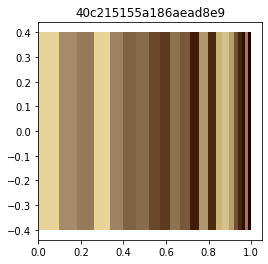

<Figure size 576x360 with 0 Axes>

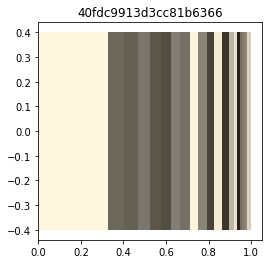

<Figure size 576x360 with 0 Axes>

In [10]:
s_s = []

for i, (index, df) in tqdm(enumerate(palette_df_bottom20.groupby('object_id'))):
#     if(i == 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()
    left = 0

    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
#         ax.barh(0, 1/len(df), color=color, left=left)
        ax.set_title('{}'.format(row['object_id']))

#         left += 1/len(df)
        left += row['ratio']

    fig.canvas.draw()
    im = np.array(fig.canvas.renderer.buffer_rgba())
    # im = np.array(fig.canvas.renderer._renderer) # matplotlibが3.1より前の場合
    im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR)
    print(get_hsv_report(im, False, True))
#     print(np.percentile(np.array(h.ravel()), 80), np.percentile(np.array(h.ravel()), 95))
#     break

95%で彩度出すとなんとなく良さげだったので，これをやってみる

In [6]:
palette_df_all = palette_df.merge(train_df, how='inner', on='object_id').sort_values(['object_id']).reset_index(drop=True)
palette_df_all

,ratio,color_r,color_g,color_b,object_id,art_series_id,title,description,long_title,principal_maker,...,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0.077440,90,55,4,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,...,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0.048071,48,36,7,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,...,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
2,0.013081,76,47,5,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,...,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
3,0.030918,68,42,5,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,...,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
4,0.074953,51,27,4,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,...,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264149,0.012121,181,91,67,fff1d87d79953ddab2c6,b5b9203624d1f0db99a9,The Adoration of the Shepherds,De aanbidding der herders. Maria knielt achter...,"The Adoration of the Shepherds, Bartolommeo Su...",Bartolommeo Suardi,...,The Adoration of the Shepherds,bequest,1941-01-01T00:00:00,"J.W.E. vom Rath Bequest, Amsterdam",1500 - 1535,1500.0,15,1500.0,1535.0,171
264150,0.024143,129,131,84,fff1d87d79953ddab2c6,b5b9203624d1f0db99a9,The Adoration of the Shepherds,De aanbidding der herders. Maria knielt achter...,"The Adoration of the Shepherds, Bartolommeo Su...",Bartolommeo Suardi,...,The Adoration of the Shepherds,bequest,1941-01-01T00:00:00,"J.W.E. vom Rath Bequest, Amsterdam",1500 - 1535,1500.0,15,1500.0,1535.0,171
264151,0.066003,47,15,0,fff1d87d79953ddab2c6,b5b9203624d1f0db99a9,The Adoration of the Shepherds,De aanbidding der herders. Maria knielt achter...,"The Adoration of the Shepherds, Bartolommeo Su...",Bartolommeo Suardi,...,The Adoration of the Shepherds,bequest,1941-01-01T00:00:00,"J.W.E. vom Rath Bequest, Amsterdam",1500 - 1535,1500.0,15,1500.0,1535.0,171
264152,0.019169,147,134,109,fff1d87d79953ddab2c6,b5b9203624d1f0db99a9,The Adoration of the Shepherds,De aanbidding der herders. Maria knielt achter...,"The Adoration of the Shepherds, Bartolommeo Su...",Bartolommeo Suardi,...,The Adoration of the Shepherds,bequest,1941-01-01T00:00:00,"J.W.E. vom Rath Bequest, Amsterdam",1500 - 1535,1500.0,15,1500.0,1535.0,171


In [12]:

s_s = []

for i, (index, df) in tqdm(enumerate(palette_df_all.groupby('object_id'))):
#     if(i == 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()
    left = 0

    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
#         ax.barh(0, 1/len(df), color=color, left=left)
        ax.set_title('{}'.format(row['object_id']))

#         left += 1/len(df)
        left += row['ratio']

    fig.canvas.draw()
    im = np.array(fig.canvas.renderer.buffer_rgba())
    # im = np.array(fig.canvas.renderer._renderer) # matplotlibが3.1より前の場合
    im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV) # hsv票色系に変換
    h,s,v = cv2.split(hsv) # 各成分に分割
    s_s.append([row['object_id'], np.percentile(np.array(v.ravel()), 50)])
#     print(np.percentile(np.array(h.ravel()), 80), np.percentile(np.array(h.ravel()), 95))
#     break

0it [00:00, ?it/s]


NameError: name 'r_s' is not defined

In [24]:
saturation_df = pd.DataFrame(s_s, columns=['object_id', 'value50'])
saturation_df

,object_id,value50
0,000405d9a5e3f49fc49d,217.0
1,001020bd00b149970f78,175.0
2,00133be3ff222c9b74b0,241.0
3,001b2b8c9d3aa1534dfe,206.0
4,00220cd4bfa082d2aa20,202.0
...,...,...
11983,fff4bbb55fd7702d294e,236.0
11984,fffbe07b997bec00e203,232.0
11985,fffd1675758205748d7f,170.0
11986,fffd43b134ba7197d890,240.0


In [25]:
saturation_df.to_csv(DATA_DIR / 'value50_test.csv', index=False)

In [7]:

s_s = []

for i, (index, df) in tqdm(enumerate(palette_df_all.groupby('object_id'))):
#     if(i == 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()
    left = 0

    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
#         ax.barh(0, 1/len(df), color=color, left=left)
        ax.set_title('{}'.format(row['object_id']))

#         left += 1/len(df)
        left += row['ratio']

    fig.canvas.draw()
    im = np.array(fig.canvas.renderer.buffer_rgba())
    # im = np.array(fig.canvas.renderer._renderer) # matplotlibが3.1より前の場合
    im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV) # hsv票色系に変換
    h,s,v = cv2.split(hsv) # 各成分に分割
    np_s = np.array(s.ravel())[12700:69700]
    np_s_ = np_s.reshape(100, -1)
    np_s__ = np.mean(np_s_, axis=0)
    s_s.append(np_s__)
    
#     break
#     print(np.percentile(np.array(h.ravel()), 80), np.percentile(np.array(h.ravel()), 95))
#     break

19it [00:01, 13.24it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
12007it [17:00, 11.77it/s]


In [8]:
train_df_likes = train_df[['object_id', 'likes']]

In [ ]:
embedding_df = pd.DataFrame(np.array(s_s), 
                            columns=[f"saturation{i}" for i in range(np.array(s_s).shape[1])])
embedding_df['object_id'] = palette_df_all['object_id'].unique()
embedding_df = pd.merge(embedding_df, train_df_likes, how='left', on='object_id')
embedding_df.head()

In [10]:
reducer = umap.UMAP(random_state=42)
reduced = reducer.fit_transform(embedding_df.iloc[:, :-2].values)
umap_df = pd.DataFrame(reduced, columns=["dim0", "dim1"], index=embedding_df.index)
umap_df.head()

,dim0,dim1
0,-1.316979,-3.709101
1,5.543149,16.657042
2,0.982904,6.243387
3,1.780858,-4.181576
4,9.987915,-3.170379


In [11]:
umap_df["likes"] =  np.log1p(embedding_df["likes"])

In [12]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="dim0", y="dim1", hue="likes", data=umap_df, alpha=0.5);

In [13]:
plt.savefig('./umap_mean.png')

In [16]:
embedding_df_output = embedding_df.drop('likes', axis=1)
embedding_df_output

,saturation0,saturation1,saturation2,saturation3,saturation4,saturation5,saturation6,saturation7,saturation8,saturation9,...,saturation561,saturation562,saturation563,saturation564,saturation565,saturation566,saturation567,saturation568,saturation569,object_id
0,125.66,130.48,130.14,130.38,130.54,126.90,127.28,127.42,128.08,125.05,...,132.80,132.46,132.70,132.86,129.22,129.60,129.74,130.41,127.15,0011d6be41612ec9eae3
1,56.33,58.41,57.97,58.03,58.47,57.03,56.91,56.67,56.06,56.22,...,59.44,59.00,59.20,59.64,58.20,58.08,57.84,57.12,57.18,0012765f7a97ccc3e9e9
2,84.85,85.55,84.33,85.71,85.43,83.89,83.75,89.32,84.94,83.46,...,86.97,85.75,87.13,86.85,85.31,85.03,90.79,86.41,84.93,00181d86ff1a7b95864e
3,130.97,136.65,137.51,137.51,138.07,133.11,133.11,133.49,133.49,133.79,...,139.07,139.93,139.93,140.49,135.53,135.53,135.91,135.91,136.21,001c52ae28ec106d9cd5
4,26.24,26.85,27.19,27.47,27.07,24.27,24.05,25.50,25.32,24.96,...,26.90,27.24,27.52,27.36,24.56,24.34,25.76,25.58,25.22,001f4c71b4d53497b531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12002,30.55,31.61,31.55,31.59,31.13,30.69,30.67,30.25,30.25,30.31,...,31.97,31.91,31.95,31.68,31.30,31.28,30.86,30.86,30.92,ffedf8af4fd5b3873164
12003,43.05,43.89,45.39,47.75,48.07,42.35,44.13,44.35,44.47,43.59,...,44.29,45.79,48.25,48.85,43.13,44.91,45.13,45.25,44.43,ffee34705ea44e1a0f79
12004,41.26,42.54,43.38,43.46,43.76,41.26,41.50,40.86,41.16,41.34,...,43.57,44.41,44.49,44.79,42.29,42.53,41.89,42.07,42.23,ffefbe1faf771aa4f790
12005,56.63,59.85,58.25,58.13,56.87,55.11,54.57,52.93,53.93,55.99,...,60.63,59.03,58.91,57.85,56.09,55.55,53.91,54.91,56.97,fff08e76cbb969eaddc7


In [18]:
embedding_df_output.to_csv(DATA_DIR / 'saturation_emb.csv', index=False)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(embedding_df.iloc[:, :-2].values)
pca_df = pd.DataFrame(reduced, columns=["dim0", "dim1"], index=embedding_df.index)
pca_df.head()

,dim0,dim1
0,1632.318693,7.913744
1,-92.185579,3.229143
2,594.592621,34.293582
3,1794.032783,1.777659
4,-858.504383,-8.230044


In [22]:
pca_df["likes"] =  np.log1p(embedding_df["likes"])

In [23]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="dim0", y="dim1", hue="likes", data=pca_df, alpha=0.5)
plt.savefig('./pca_mean.png')

パレットをそのままCNNにぶちこんだらどう？と思って，画像化して保存

In [13]:
output_dir = DATA_DIR / 'img'

In [21]:
whole_df = pd.concat([train_df, test_df]).reset_index(drop=True)

palette_df_all = palette_df.merge(whole_df, how='inner', on='object_id').sort_values(['object_id'])
palette_df_all

,ratio,color_r,color_g,color_b,object_id,art_series_id,title,description,long_title,principal_maker,...,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0.013781,40,4,0,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,...,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
21,0.049443,199,153,89,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,...,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
20,0.042023,67,25,4,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,...,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
19,0.043007,80,36,10,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,...,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
18,0.048686,92,48,19,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,...,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527869,0.046813,116,91,61,ffff22ea12d7f99cff31,3a43fbb8b3a88d712bf5,Boom gezien door een ruïne in Engeland,Onderdeel van Album met foto's van bezienswaar...,"Boom gezien door een ruïne in Engeland, anonym...",anonymous,...,Boom gezien door een ruïne in Engeland,transfer,1994-01-01T00:00:00,NaN,c. 1850 - c. 1870,1850.0,19,1850.0,1870.0,NaN
527868,0.039409,146,119,76,ffff22ea12d7f99cff31,3a43fbb8b3a88d712bf5,Boom gezien door een ruïne in Engeland,Onderdeel van Album met foto's van bezienswaar...,"Boom gezien door een ruïne in Engeland, anonym...",anonymous,...,Boom gezien door een ruïne in Engeland,transfer,1994-01-01T00:00:00,NaN,c. 1850 - c. 1870,1850.0,19,1850.0,1870.0,NaN
527888,0.052426,107,81,49,ffff22ea12d7f99cff31,3a43fbb8b3a88d712bf5,Boom gezien door een ruïne in Engeland,Onderdeel van Album met foto's van bezienswaar...,"Boom gezien door een ruïne in Engeland, anonym...",anonymous,...,Boom gezien door een ruïne in Engeland,transfer,1994-01-01T00:00:00,NaN,c. 1850 - c. 1870,1850.0,19,1850.0,1870.0,NaN
527877,0.061024,195,167,91,ffff22ea12d7f99cff31,3a43fbb8b3a88d712bf5,Boom gezien door een ruïne in Engeland,Onderdeel van Album met foto's van bezienswaar...,"Boom gezien door een ruïne in Engeland, anonym...",anonymous,...,Boom gezien door een ruïne in Engeland,transfer,1994-01-01T00:00:00,NaN,c. 1850 - c. 1870,1850.0,19,1850.0,1870.0,NaN


In [22]:
for i, (index, df) in tqdm(enumerate(palette_df_all.groupby('object_id'))):
#     if(i == 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.ioff()
    left = 0

    for index, row in df.sort_values('ratio', ascending=False).iterrows():
#         print(np.var(row['color_r']))
        r_s.append(row['color_r'])
        g_s.append(row['color_g'])
        b_s.append(row['color_b'])
        color = '#' + format(row['color_r'], '02x') + format(row['color_g'], '02x') + format(row['color_b'], '02x')
        ax.barh(0, row['ratio'], color=color, left=left)
#         ax.barh(0, 1/len(df), color=color, left=left)
#         ax.set_title('{}'.format(row['object_id']))

#         left += 1/len(df)
        left += row['ratio']
    ax.axis("off")
    fig.savefig(output_dir / str(row['object_id'] + "png"))
#     break


13it [00:00, 25.28it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
23995it [17:28, 22.89it/s]


### マテリアル情報をカテゴリ化して，one_hotになおして保存
https://www.guruguru.science/competitions/16/discussions/39b98f2e-ad1f-4637-9cb0-52d3f533873a/

In [8]:
from typing import Dict
import yaml

In [7]:
def convert_onehot_materials(input_df: pd.DataFrame
                           , converter: Dict[str, str]) -> pd.DataFrame:
    output_df = pd.DataFrame()

    ids = input_df["object_id"].unique()
    # 行方向は object_id に対応（ユニーク数と同じ行数）
    # 列方向は converter で変換したいカテゴリ数と同じ数、 OneHotEncodingする
    onehot_mats = np.zeros(
        (len(ids), len(converter.keys()))
    )
    for idx, _id in tqdm(enumerate(ids)):
        mats = input_df[input_df["object_id"] == _id]["name"].values
        for mat in mats:
            for i, (k, v) in enumerate(converter.items()):
                if mat in v:
                    onehot_mats[idx, i] = 1
                    break

    output_df["object_id"] = ids
    for i, k in enumerate(converter.keys()):
        output_df[f"OH_material_{k}"] = onehot_mats[:, i]
        output_df[f"OH_material_{k}"] = output_df[f"OH_material_{k}"].astype(int)

    return output_df


def preprocess_material(input_df: pd.DataFrame) -> pd.DataFrame:
    with open("./materials_converter.yml", 'r', encoding="utf-8") as f:
            converter = yaml.safe_load(f)

    return convert_onehot_materials(input_df, converter)

In [21]:
material = pd.read_csv(DATA_DIR / 'material.csv')
material_df = preprocess_material(material)
material_df

23586it [00:32, 726.84it/s]


,object_id,OH_material_paper,OH_material_metal,OH_material_glass,OH_material_wood,OH_material_oil,OH_material_board,OH_material_canvas,OH_material_panel,OH_material_fabric,OH_material_ink,OH_material_drawer,OH_material_animal,OH_material_rock
0,000405d9a5e3f49fc49d,1,0,0,0,0,1,0,0,0,0,0,0,0
1,001020bd00b149970f78,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0011d6be41612ec9eae3,0,0,0,0,1,0,1,0,0,0,0,0,0
3,0012765f7a97ccc3e9e9,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00133be3ff222c9b74b0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23581,fff1d87d79953ddab2c6,0,0,0,0,1,0,0,1,0,0,0,0,0
23582,fff4bbb55fd7702d294e,1,0,0,0,0,0,0,0,0,0,0,0,0
23583,fffbe07b997bec00e203,1,0,0,0,0,1,0,0,0,0,0,0,0
23584,fffd43b134ba7197d890,1,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
material_df.to_csv(DATA_DIR / 'material_info.csv', index=False)

In [31]:
def convert_onehot_techniques(input_df: pd.DataFrame
                           , converter: Dict[str, str]) -> pd.DataFrame:
    output_df = pd.DataFrame()

    ids = input_df["object_id"].unique()
    # 行方向は object_id に対応（ユニーク数と同じ行数）
    # 列方向は converter で変換したいカテゴリ数と同じ数、 OneHotEncodingする
    onehot_mats = np.zeros(
        (len(ids), len(converter.keys()))
    )
    for idx, _id in tqdm(enumerate(ids)):
        mats = input_df[input_df["object_id"] == _id]["name"].values
        for mat in mats:
            for i, (k, v) in enumerate(converter.items()):
                if mat in v:
                    onehot_mats[idx, i] = 1
                    break

    output_df["object_id"] = ids
    for i, k in enumerate(converter.keys()):
        output_df[f"OH_tech_{k}"] = onehot_mats[:, i]
        output_df[f"OH_tech_{k}"] = output_df[f"OH_tech_{k}"].astype(int)

    return output_df


def preprocess_technique(input_df: pd.DataFrame) -> pd.DataFrame:
    with open("./technique_converter.yml", 'r', encoding="utf-8") as f:
            converter = yaml.safe_load(f)

    return convert_onehot_techniques(input_df, converter)

In [32]:
material = pd.read_csv(DATA_DIR / 'technique.csv')
material_df = preprocess_technique(material)
material_df

17329it [00:15, 1098.31it/s]


,object_id,OH_tech_printmake,OH_tech_engraving,OH_tech_photo,OH_tech_printing,OH_tech_paint,OH_tech_gilding,OH_tech_lace,OH_tech_cut
0,000405d9a5e3f49fc49d,0,0,1,0,0,0,0,0
1,0012765f7a97ccc3e9e9,0,0,1,1,0,0,0,0
2,00133be3ff222c9b74b0,1,0,0,0,0,0,0,0
3,0017be8caa87206532cb,0,0,1,0,0,0,0,0
4,001f4c71b4d53497b531,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
17324,fff4bbb55fd7702d294e,0,0,1,0,0,0,0,0
17325,fffbe07b997bec00e203,0,0,1,0,0,0,0,0
17326,fffd1675758205748d7f,0,0,1,0,0,0,0,0
17327,fffd43b134ba7197d890,0,0,1,0,0,0,0,0


In [33]:
material_df.to_csv(DATA_DIR / 'technique_info.csv', index=False)

In [14]:
def convert_onehot_places(input_df: pd.DataFrame
                           , converter: Dict[str, str]) -> pd.DataFrame:
    output_df = pd.DataFrame()

    ids = input_df["object_id"].unique()
    # 行方向は object_id に対応（ユニーク数と同じ行数）
    # 列方向は converter で変換したいカテゴリ数と同じ数、 OneHotEncodingする
    onehot_mats = np.zeros(
        (len(ids), len(converter.keys()))
    )
    for idx, _id in tqdm(enumerate(ids)):
        mats = input_df[input_df["object_id"] == _id]["name"].values
        for mat in mats:
            for i, (k, v) in enumerate(converter.items()):
                if mat in v:
                    onehot_mats[idx, i] = 1
                    break

    output_df["object_id"] = ids
    for i, k in enumerate(converter.keys()):
        output_df[f"OH_place_{k}"] = onehot_mats[:, i]
        output_df[f"OH_place_{k}"] = output_df[f"OH_place_{k}"].astype(int)

    return output_df


def preprocess_places(input_df: pd.DataFrame) -> pd.DataFrame:
    with open("./country_converter.yml", 'r', encoding="utf-8") as f:
            converter = yaml.safe_load(f)

    return convert_onehot_places(input_df, converter)

In [15]:
country = pd.read_csv(DATA_DIR / 'production_place_country_raw.csv')
country = country.rename(columns={"country_name":"name"})
country = country.dropna(how='any')
country_df = preprocess_places(country)
country_df

15546it [00:13, 1144.40it/s]


,object_id,OH_place_Asia,OH_place_Europe,OH_place_United States
0,0012765f7a97ccc3e9e9,0,1,0
1,00133be3ff222c9b74b0,0,1,0
2,0017be8caa87206532cb,0,1,0
3,001b2b8c9d3aa1534dfe,0,1,0
4,001c52ae28ec106d9cd5,0,1,0
...,...,...,...,...
15541,ffefbe1faf771aa4f790,0,1,0
15542,fff08e76cbb969eaddc7,0,1,0
15543,fffbe07b997bec00e203,0,1,0
15544,fffd43b134ba7197d890,0,1,0


In [17]:
country_df.to_csv(DATA_DIR / 'place_info.csv', index=False)